## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, save_dir_, pre_model_save_path_):
        
        self.pre_model_save_path = pre_model_save_path_
        self.save_dir = save_dir_
        
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        #PDE parameters
        self.alpha_f = 0.05
        self.h_f = 5.0
        self.T_hot = 4.0
        self.U_f = 1.0
        self.alpha_s = 0.08
        self.h_s = 6.0
        self.T_0 = 1.0
        
        # Extrema of the solution domain (t,x) in [0,1]x[0,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''
        
        if pre_model_save_path_:
            load_checkpoint()

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition
    def initial_condition(self, x):
        return torch.full([len(x),2], self.T_0)

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1])

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the PDE residuals u[1] -> T_f, u[2] -> T_s
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)
        Tf = u[:,0].reshape(-1,1)
        Ts = u[:,1].reshape(-1,1)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_Tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_Tf_t = grad_Tf[:, 0]
        grad_Tf_x = grad_Tf[:, 1]
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:, 1]
        
        grad_Ts = torch.autograd.grad(Ts.sum(), input_int, create_graph=True)[0]
        grad_Ts_t = grad_Ts[:, 0]
        grad_Ts_x = grad_Ts[:, 1]
        grad_Ts_xx = torch.autograd.grad(grad_Ts_x.sum(), input_int, create_graph=True)[0][:, 1]        

        residual_Tf = grad_Tf_t + self.U_f * grad_Tf_x - self.alpha_f * grad_Tf_xx + self.h_f * (Tf - Ts)[:,0]
        residual_Ts = grad_Ts_t - self.alpha_s * grad_Ts_xx  - self.h_s * (Tf - Ts)[:,0]
#        residual = torch.abs(residual_Tf) + torch.abs(residual_Ts)
        
        return residual_Ts.reshape(-1, ), residual_Tf.reshape(-1, )
    
    def compute_bc0_residual(self, input_bc):
        input_bc.requires_grad = True
        
        u = self.approximate_solution(input_bc)
        Tf = u[:,0].reshape(-1,1)
        Ts = u[:,1].reshape(-1,1)
        
        #solid
        grad_Ts = torch.autograd.grad(Ts.sum(), input_bc, create_graph=True)[0]
        grad_Ts_x = grad_Ts[:, 1]
        # fluid
        rhs = (self.T_hot - self.T_0) / (1 + torch.exp(-200 * (input_bc[:,0:1] - 0.25))) + self.T_0
        
        residual_Ts = grad_Ts_x
        residual_Tf = Tf[:,0] - rhs[:,0]
#        residual = torch.abs(residual_Tf) + torch.abs(residual_Ts)
        
        return residual_Ts.reshape(-1, ), residual_Tf.reshape(-1, )
        
    def compute_bcL_residual(self, input_bc):
        input_bc.requires_grad = True
        u = self.approximate_solution(input_bc)
        Tf = u[:,0].reshape(-1,1)
        Ts = u[:,1].reshape(-1,1) 
        
        # solid
        grad_Ts = torch.autograd.grad(Ts.sum(), input_bc, create_graph=True)[0]
        grad_Ts_x = grad_Ts[:, 1]
        # fluid
        grad_Tf = torch.autograd.grad(Tf.sum(), input_bc, create_graph=True)[0]
        grad_Tf_x = grad_Tf[:, 1]       
        
        residual_Ts = grad_Ts_x
        residual_Tf = grad_Tf_x
#        residual = torch.abs(residual_Tf) + torch.abs(residual_Ts)

        return residual_Ts.reshape(-1, ), residual_Tf.reshape(-1, )
    

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        r_int_s, r_int_f = self.compute_pde_residual(inp_train_int)
        r_sb0_s, r_sb0_f = self.compute_bc0_residual(inp_train_sb[0:self.n_sb,:])
        r_sbL_s, r_sbL_f = self.compute_bcL_residual(inp_train_sb[self.n_sb:,:])
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb0_s) ** 2) + torch.mean(abs(r_sb0_f) ** 2) + torch.mean(abs(r_sbL_s) ** 2) + torch.mean(abs(r_sbL_f) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int_s) ** 2) + torch.mean(abs(r_int_f) ** 2)
        
#         r_int = self.compute_pde_residual(inp_train_int)
#         r_tb = u_train_tb - u_pred_tb
#         r_sb_0 = self.compute_bc0_residual(inp_train_sb[0:self.n_sb,:])
#         r_sb_L = self.compute_bcL_residual(inp_train_sb[self.n_sb:,:])
        
#         loss_tb = torch.mean(abs(r_tb) ** 2)
#         loss_int = torch.mean(abs(r_int) ** 2)
#         loss_sb = torch.mean(abs(r_sb_0) ** 2) + torch.mean(abs(r_sb_L) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss
                

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history
    
    def save_checkpoint(self):
        '''save model and optimizer'''
        torch.save({
            'model_state_dict': self.approximate_solution.state_dict()
        }, self.save_dir)
        
    def load_checkpoint(self):
        '''load model and optimizer'''
        checkpoint = torch.load(self.pre_model_save_path)
        self.approximate_solution.load_state_dict(checkpoint['model_state_dict'])
        print('Pretrained model loaded!')

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output_f = self.approximate_solution(inputs)[:,0:1].reshape(-1, )
        output_s = self.approximate_solution(inputs)[:,1:2].reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_s.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_f.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Solid Temperature")
        axs[1].set_title("Fluid Temperature")

        plt.show()
        # err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        # print("L2 Relative Error Norm: ", err.item(), "%")


In [3]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64


pre_model_save_path = None
save_path = './model/Adam1000_sqloss.pt'
pinn = Pinns(n_int, n_sb, n_tb, save_path, pre_model_save_path)

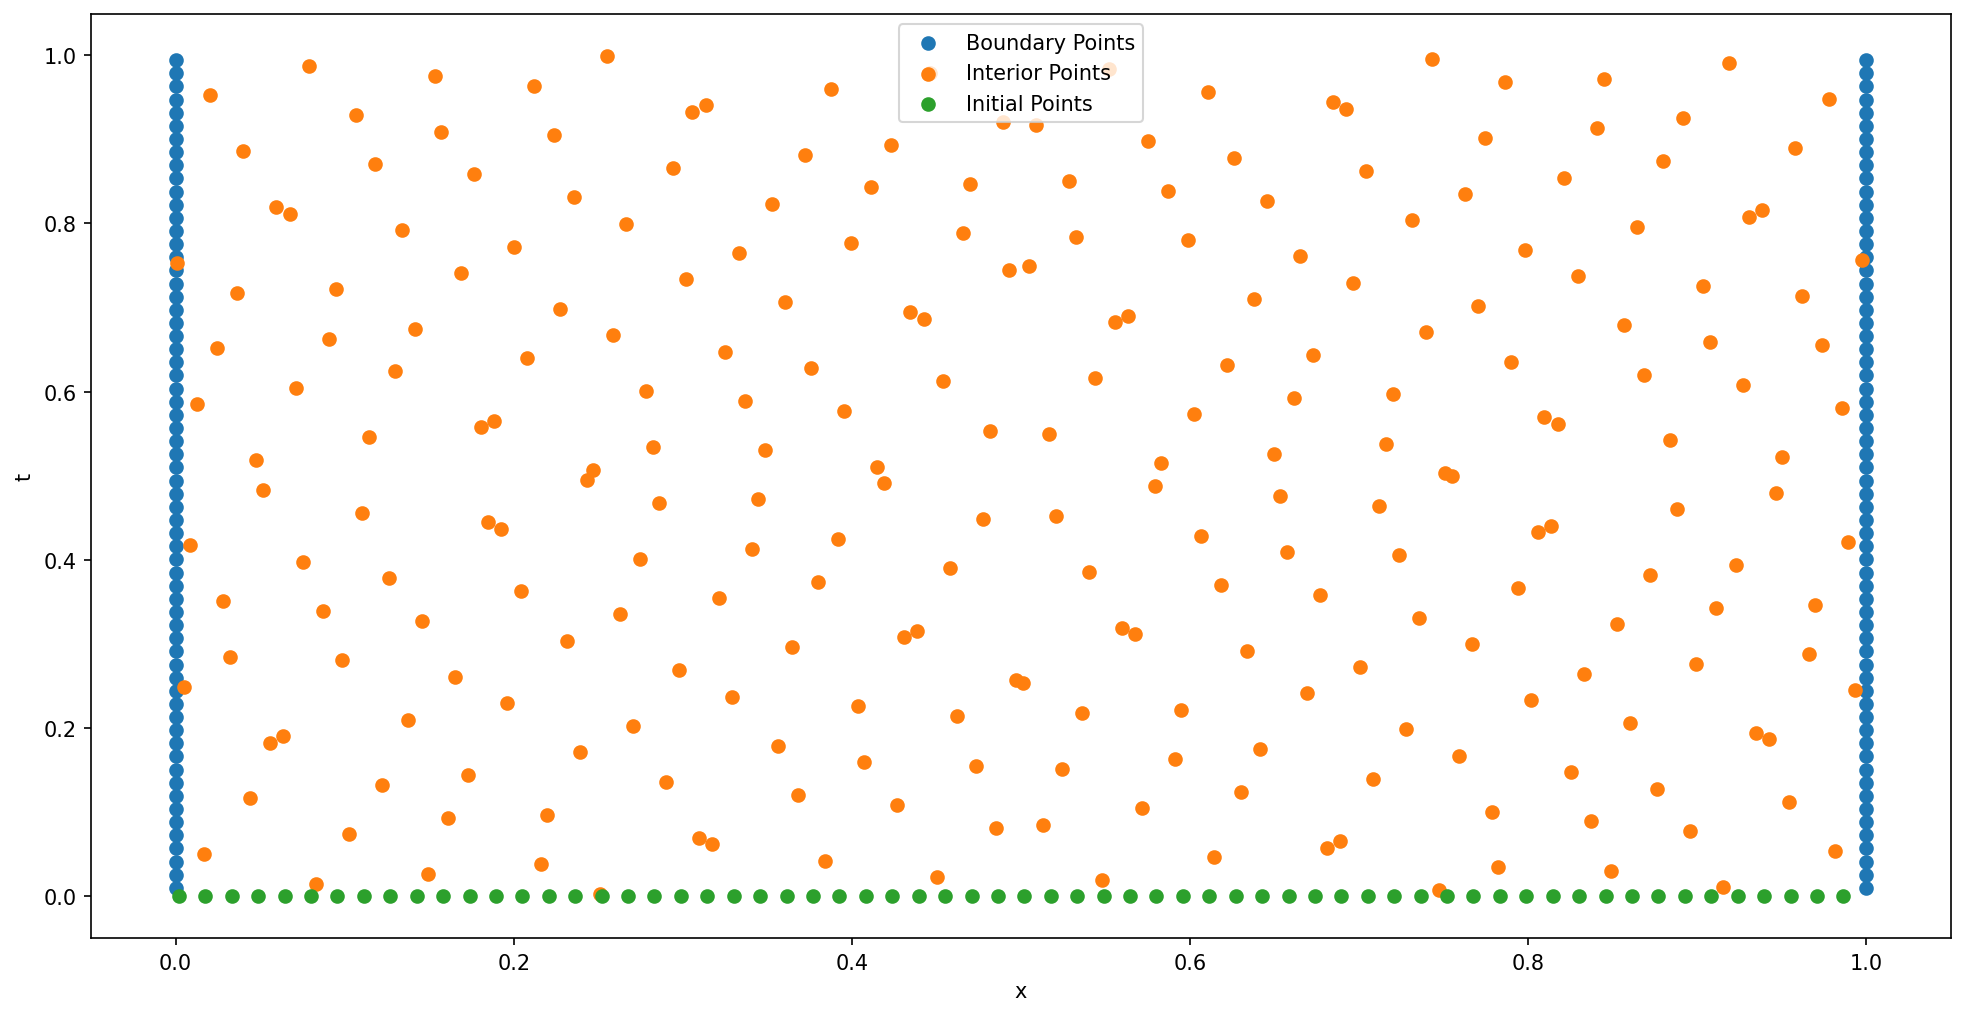

In [4]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

################################  0  ################################
Total loss:  -1.1834 | PDE Loss:  -2.5907 | Function Loss:  -1.3992
Total loss:  0.6446 | PDE Loss:  -0.3622 | Function Loss:  -1.1625
Total loss:  -1.0373 | PDE Loss:  -2.2836 | Function Loss:  -1.401
Total loss:  -1.1978 | PDE Loss:  -2.6267 | Function Loss:  -1.4002
Total loss:  -1.198 | PDE Loss:  -2.6269 | Function Loss:  -1.4004
Total loss:  -1.1982 | PDE Loss:  -2.6268 | Function Loss:  -1.4008
Total loss:  -1.1984 | PDE Loss:  -2.6265 | Function Loss:  -1.4012
Total loss:  -1.1985 | PDE Loss:  -2.6261 | Function Loss:  -1.4016
Total loss:  -1.1985 | PDE Loss:  -2.6258 | Function Loss:  -1.4019
Total loss:  -1.1986 | PDE Loss:  -2.6256 | Function Loss:  -1.4021
Total loss:  -1.1986 | PDE Loss:  -2.6254 | Function Loss:  -1.4023
Total loss:  -1.1987 | PDE Loss:  -2.6253 | Function Loss:  -1.4025
Total loss:  -1.1988 | PDE Loss:  -2.6253 | Function Loss:  -1.4027
Total loss:  -1.199 | PDE Loss:  -2.6253 | Functi

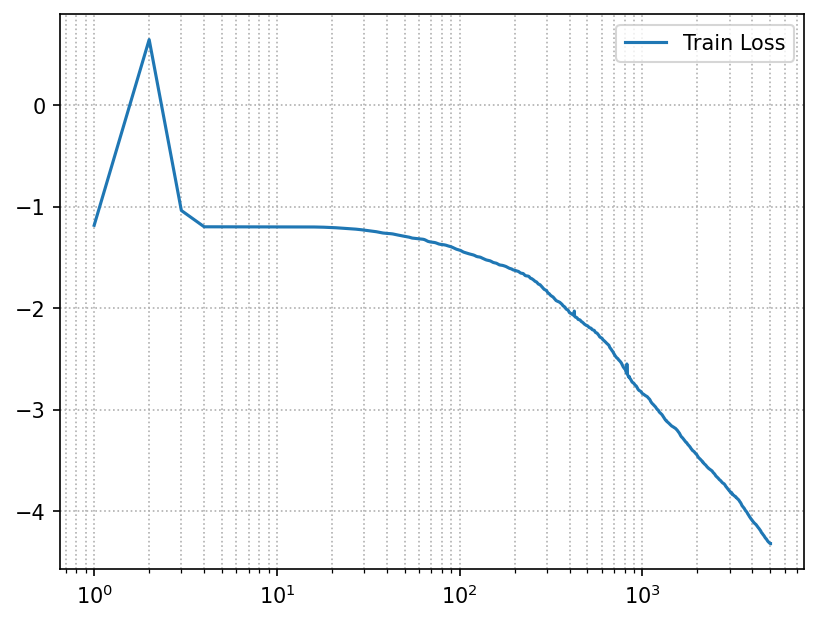

In [8]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

pinn.save_checkpoint()

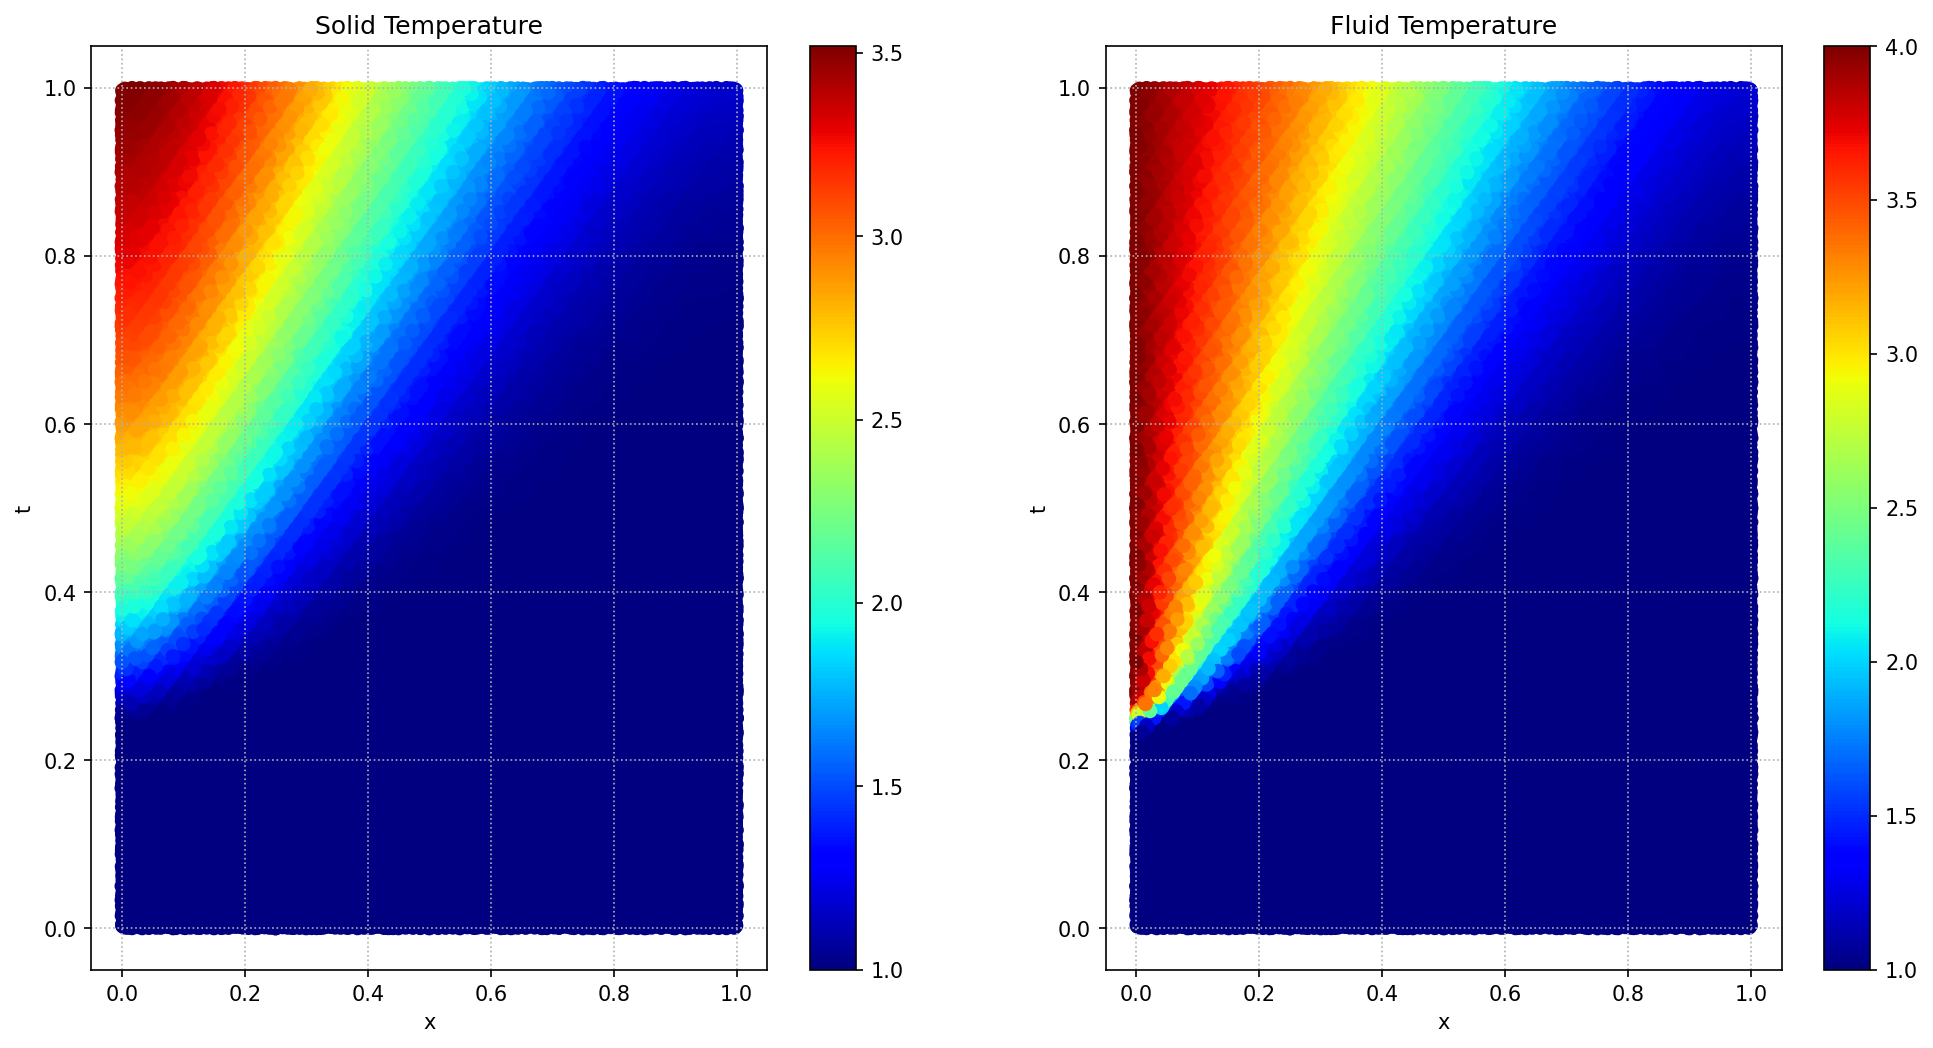

In [9]:
pinn.plotting()

In [23]:
import pandas as pd
test_data = torch.tensor(pd.read_table('data/TestingData.txt', sep=',').values, dtype = float)

In [24]:
print(test_data)
output_function_test_pred = pinn.approximate_solution(test_data.float())

tensor([[0.6241, 0.8950],
        [0.7835, 0.7780],
        [0.3981, 0.4690],
        ...,
        [0.7189, 0.1000],
        [0.9540, 0.2470],
        [0.4636, 0.7400]], dtype=torch.float64)


In [28]:
solution = torch.cat((test_data,output_function_test_pred), 1)
np.savetxt('data/result.txt', solution.detach().numpy(),delimiter=',',header='t,x,tf,ts')